In [1]:
#define the colors from colorbrewer2
orange1 = '#feedde'
orange2 = '#fdbe85'
orange3 = '#fd8d3c'
orange4 = '#e6550d'
orange5 = '#a63603'
blue1 = '#eff3ff'
blue2 = '#bdd7e7'
blue3 = '#6baed6'
blue4 = '#3182bd'
blue5 = '#08519c'
green1 = '#edf8e9'
green2 = '#bae4b3'
green3 = '#74c476'
green4 = '#31a354'
green5 = '#006d2c'
grey1 = '#f7f7f7'
grey2 = '#cccccc'
grey3 = '#969696'
grey4 = '#636363'
grey5 = '#252525'
purple1 = '#f2f0f7'
purple2 = '#cbc9e2'
purple3 = '#9e9ac8'
purple4 = '#756bb1'
purple5 = '#54278f'
red1 = '#fee5d9'
red2 = '#fcae91'
red3 = '#fb6a4a'
red4 = '#de2d26'
red5 = '#a50f15'

In [2]:
# Lists of colors for plots
c0 = (0.76, 0.76, 0.76)
c1 = (1.00, 0.18, 0.33);
c2 = (1.00, 0.23, 0.19);
c3 = (1.00, 0.58, 0.00);
c4 = (1.00, 0.80, 0.00);
c5 = (0.30, 0.85, 0.39);
c6 = (0.35, 0.78, 0.98);
c7 = (0.20, 0.67, 0.86);
c8 = (0.00, 0.48, 1.00);
c9 = (0.35, 0.34, 0.84);
c10 = (0.00, 0.31, 0.57);
c11 = (0.12, 0.29, 0.69);
c12 = (0.17, 0.17, 0.42);
c13 = (1.00, 1.00, 1.00);
c14 = (0.77, 0.04, 0.00);

In [3]:
# imported packages
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import matplotlib.ticker as plticker
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib.patches import Polygon
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib import cm
import scipy.special
import scipy.integrate as it
from scipy import integrate
from scipy.interpolate import interp1d
from scipy.stats import kde
import copy
import glob, os
import re
from sklearn import datasets, linear_model
import pandas as pd
from decimal import *
from operator import itemgetter    
from collections import OrderedDict
import timeit
import csv
from scipy.integrate import simps

# Importing data

In [4]:
# All synonymous variants (in any gene)
filename="Acuna_Hidalgo_2017_SNVs.csv"
with open(filename, 'r') as csvfile:
    read_reader = csv.reader(csvfile)  #csv.reader returns a reader object which will iterate over lines in the csvfile
    row_count=0
    Acuna_synonymous_results={} 
    
    for row in read_reader:
        if row_count>0: #ignore the header of the CSV file
            if row[8]=='synonymous': #only look at the synonymous variants (in any gene)
#                 print(row)
                VAF = row[2]
                ID = row[7] #participant ID
                age = float(row[0])
                mutation_type = row[8] #synonymous
                AA = row[6] #AA change, e.g. P9P
                gene = row[1] #gene in which variant falls
                Acuna_synonymous_results[row_count]=(ID, VAF, age, mutation_type, AA, gene)

        row_count=row_count+1

Acuna_synonymous = sorted(Acuna_synonymous_results.items(), key=lambda x: x[1][1], reverse=True)


# All synonymous variants (in any gene)
import csv
filename="Young_2016_SNVs.csv" #CSV file containing SNVs reported in Young 2016 and Young 2019 (only controls), but only includes 1 time-point (the earliest time-point at which a variant was detected in that individual)
with open(filename, 'r') as csvfile:
    read_reader = csv.reader(csvfile)  #csv.reader returns a reader object which will iterate over lines in the csvfile
    row_count=0
    Young2016_synonymous={}
    
    for row in read_reader:
        if row[15]!='-': #only look at variants that were present in the individual's baseline samples
            VAF = row[15] #In the csv file this is the average of the replicates at that time-point (VAFs that were '-' in original file were ignored)
            ID = row[0] #participant ID
            mutation_type = row[17] #whether the variant is missense or nonsense or synonymous
            age = row[13]
            AA = row[7] #AA change, e.g. P9P
            if mutation_type == 'synonymous':
                Young2016_synonymous[row_count]=(ID, VAF, mutation_type, AA, age)
                        
        row_count=row_count+1
        
Young2016_synonymous = sorted(Young2016_synonymous.items(), key=lambda x: x[1][1], reverse=True)


# All synonymous variants (in any gene)
import csv
filename="Young_2019_SNVs.csv" #CSV file containing SNVs reported in Young 2019 and Young 2019 (only controls), but only includes 1 time-point (the earliest time-point at which a variant was detected in that individual)
with open(filename, 'r') as csvfile:
    read_reader = csv.reader(csvfile)  #csv.reader returns a reader object which will iterate over lines in the csvfile
    row_count=0
    Young2019_synonymous={}
    
    for row in read_reader:
        if row[2]!='case': #only look at the controls
            if row[7]!='-': #only look at variants that were present in the individual's baseline samples
                VAF = row[7] #In the csv file this is the average of the replicates at that time-point (VAFs that were '-' in original file were ignored)
                ID = row[0] #participant ID
                mutation_type = row[4] #whether the variant is missense or nonsense or synonymous
                age = row[9]
                AA = row[5] #AA change, e.g. P9P
                if mutation_type == 'synonymous':
                    Young2019_synonymous[row_count]=(ID, VAF, mutation_type, AA, age)

        row_count=row_count+1
        
Young2019_synonymous = sorted(Young2019_synonymous.items(), key=lambda x: x[1][1], reverse=True)

# Trimming synonymous variant data

In [5]:
Young2016_synonymous_trimmed_list = []
Young2019_synonymous_trimmed_list = []
Young2016_2019_synonymous_trimmed_list = []
Acuna_synonymous_trimmed_list = []

Acuna_limit_log10 = -2.81029625 #previously -2.78675013
Young2016_limit_log10 = -2.95376946
Young2018_limit_log10 = -3.0617603

Acuna_limit = 10**(Acuna_limit_log10) #previously -2.78675013
Young2016_limit = 10**(Young2016_limit_log10) #previously -2.95376946
Young2019_limit = 10**(Young2018_limit_log10)

for (row_count,  VAF) in Acuna_synonymous:
    if float(VAF[1])>=Acuna_limit:
        Acuna_synonymous_trimmed_list.append(VAF[1])
    
for (ID,  VAF) in Young2016_synonymous:
    if float(VAF[1])>=Young2016_limit:
        Young2016_synonymous_trimmed_list.append(VAF[1])

for (ID,  VAF) in Young2019_synonymous:
    if float(VAF[1])>=Young2019_limit:
        Young2019_synonymous_trimmed_list.append(VAF[1])

# COMBINING YOUNG 2016 & 2019
for (ID,  VAF) in Young2016_synonymous:
    if float(VAF[1])>=Young2016_limit:
        Young2016_2019_synonymous_trimmed_list.append(VAF[1])

for (ID,  VAF) in Young2019_synonymous:
    if float(VAF[1])>=Young2019_limit:
        Young2016_2019_synonymous_trimmed_list.append(VAF[1])

# Normalize VAF densities

In [6]:
def normalised_VAF_normalised_densities_list(trimmed_VAF_list, study_total, mu, binmethod):
    y1 = []
    for i in trimmed_VAF_list:
        VAFs = float(i)
        y = np.log(VAFs)
        y1.append(y)
        
    normed_value = study_total*2*mu
    hist, bins = np.histogram(y1, bins=binmethod, range=(min(y1),max(y1)))
    widths = np.diff(bins)
    bin_centres = (bins[:-1] + bins[1:])/2
    hist = np.array(hist, dtype=float)
    normalised_hist = hist/(normed_value*widths)
    log_hist_for_plot = np.log(normalised_hist)

    errors = error_bars(hist, normed_value, widths)
    
    VAF_densities=[]
    lower_error = []
    upper_error = []
    for i in errors[0]:
        lower_error.append(i)
    for i in errors[1]:
        upper_error.append(i)
    VAF_densities_zip = zip(bin_centres, log_hist_for_plot, lower_error, upper_error)
    for a, b, c, d in VAF_densities_zip:
        VAF_densities.append((a, b, c, d))
        
    return VAF_densities

def error_bars(hist, normed_value, widths):
    
    errors={}
    n=0
    for i in list(hist):
        normalised_hist = i/(normed_value*widths)
        log_hist = np.log(normalised_hist)
        sqrt_hist = math.sqrt(i)
        if sqrt_hist == 1:
            upper_error = 1
            lower_error = 0.9
        if sqrt_hist !=1:
            upper_error = sqrt_hist
            lower_error = sqrt_hist
        normalised_upper_error = upper_error/(normed_value*widths)
        normalised_lower_error = lower_error/(normed_value*widths)
        errors[n]=(normalised_hist[0], normalised_upper_error[0], normalised_lower_error[0])
        n = n+1

    errors_corrected ={}
    for k, v in errors.items():
        binheight = v[0]
        log_binheight = np.log(v[0])
        upper_error = v[1]
        lower_error = v[2]
        log_upper_error = (np.log(upper_error+binheight))-log_binheight
        log_lower_error = log_binheight-(np.log(binheight-lower_error))
        errors_corrected[k] = (log_binheight, log_upper_error, log_lower_error)

    lower_err=[]
    upper_err=[]
    for k, v in errors_corrected.items():
        lower_error = v[2]
        upper_error = v[1]
        lower_err.append(lower_error)
        upper_err.append(upper_error)

    err = [tuple(lower_err),tuple(upper_err)]
    
    return err

In [7]:
Youngtotal = 20
Young2019totalcontrols = 69
Acunatotal = 2006

# Synonymous variants mutation rates
Young_synonymous_mu = 7.60E-05
Acuna_synonymous_mu = 2.68E-06

binmethod = 'doane'
young_synonymous_bins = 6

Young_VAF_densities_neutral = normalised_VAF_normalised_densities_list(Young2016_2019_synonymous_trimmed_list, Youngtotal+Young2019totalcontrols, Young_synonymous_mu, young_synonymous_bins)
Acuna_VAF_densities_neutral = normalised_VAF_normalised_densities_list(Acuna_synonymous_trimmed_list, Acunatotal, Acuna_synonymous_mu, binmethod)



# Synonymous densities (normalised by 2 x mu)
Neutral_densities = Young_VAF_densities_neutral+Acuna_VAF_densities_neutral

Neutral_densities_without_inf = []    #remove the densities for the VAF bins for which there were no densities
for i in Neutral_densities:
    if i[1] != -(float('inf')):
        Neutral_densities_without_inf.append(i)

C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log
C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in log
C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log
C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in log
C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


# Applying s distribution

In [8]:
N = 9.39358404e+04

# def mu_of_s(b, d, s, u, s_max): #mutation rate across an exponential distribution of s
#     s_peak = 0.0
#     weight_s= lambda s: np.exp(-((abs(s-s_peak))/d)**b)
#     normalization=integrate.quad(weight_s, 0.0, s_max)[0]
#     return (u)*np.exp(-((abs(s))/d)**b)/normalization




def expected_density_b_to_n_mutants_s_single(t, l, s1, b, d, mu_ben, s_max): #s1 = fitness of 1st mutation, s2 = fitness of 2nd mutation
    combined_s=s1#sum of the fitness effects of the 2 mutations
    s_peak = 0.0
    weight_s= lambda s: np.exp(-((abs(s-s_peak))/d)**b)
    normalization=integrate.quad(weight_s, 0.0, s_max)[0]
    mu1 = mu_ben*np.exp(-((abs(s1))/d)**b)/normalization
     #mutation rate for 1st mutation with exponential distribution of s
    mu2 = 1/2 #mutation rate for 2nd mutation with exponential distribution of s
    n = (2*N*np.exp(l))/(1-2*np.exp(l))
    psi = (np.exp(s1*t)-1)/s1
    
    expected_density = N*mu1*mu2*np.exp(l)/((2*N*np.exp(l)/(1-2*np.exp(l)))*s1+1)*\
    (np.exp(s1*t)/((2*N*np.exp(l)/(1-2*np.exp(l)))*s1+1)-1 +s1*t-np.log((2*N*np.exp(l)/(1-2*np.exp(l)))*s1+1)  )*(2*N/(1-2*np.exp(l))+4*N*np.exp(l)/(1-2*np.exp(l))**2)
        

    for i in range(len(s1)):
        if expected_density[i]<0:
            expected_density[i] = 0
        
    return (expected_density)

# def expected_density_eff(t, l, mu_eff, s_eff): #s1 = fitness of 1st mutation, s2 = fitness of 2nd mutation
#     mu1 = mu_eff #mutation rate for 1st mutation with exponential distribution of s
#     mu2 = 1/2 #mutation rate for 2nd mutation with exponential distribution of s
#     n = (2*N*np.exp(l))/(1-2*np.exp(l))
#     psi = (np.exp(s_eff*t)-1)/s_eff
    
#     expected_density = N*mu_eff*mu2*np.exp(l)/((2*N*np.exp(l)/(1-2*np.exp(l)))*s_eff+1)*\
#     (np.exp(s_eff*t)/((2*N*np.exp(l)/(1-2*np.exp(l)))*s_eff+1)-1 +\
#      s_eff*t-np.log((2*N*np.exp(l)/(1-2*np.exp(l)))*s_eff+1)  )*(2*N/(1-2*np.exp(l))+4*N*np.exp(l)/(1-2*np.exp(l))**2)

#     for i in range(len(s1)):
#         if expected_density[i]<0:
#             expected_density[i] = 0
        
#     return (expected_density)

# def expected_number_b_to_n_mutants(t, l, b, d, mu_ben, s_max):
#     return integrate.quad(lambda s1: expected_density_b_to_n_mutants_s_single(t,  l, s1, b, d, mu_ben, s_max), 0, s_max)[0]

def expected_number_b_to_n_mutants(t_var, l, b, d, mu_ben, s_max):
    return integrate.simps(expected_density_b_to_n_mutants_s_single(t_var,  l, np.linspace(0, s_max, 10000), b, d, mu_ben, s_max),np.linspace(0, s_max, 10000))

In [18]:
# b=0.33
# d=3.4e-4
# s_max=0.161
# s_peak = 0.0
# result=expected_number_b_to_n_mutants(80, -3, b, d, 10**-5, 0.1)
# result2=expected_number_b_to_n_mutants(80, -3, b, d, 10**-5, 0.05)

In [11]:
# result2

0.0

In [ ]:
# def myintegrate(x_min, x_max, fineness):
#     s_vector=np.linspace(x_min, x_max, fineness)
#     Big_sum=0
#     for s in s_vector:
#         Big_sum=Big_sum+mu_of_s(b, d, s, 1, x_max)
# #function to be integrated
#     normalization2=len(s_vector)
#     integration=Big_sum/normalization2
#     return integration

In [ ]:
# plt.close('all')
# scale = 1.2
# f, ax1 = plt.subplots(2, 1, figsize=(12*scale, 12*scale))
# font = {'weight' : 'normal','size'   : 16}
# matplotlib.rc('font', **font)

# b=0.33
# d=3.4e-4
# s_max=0.161
# s_peak = 0.0

# def mu_of_s(bb, dd, ss, uu, s_max_nested): #mutation rate across an exponential distribution of s
#     s_peak = 0.0
#     weight_s= lambda x: np.exp(-((abs(x-s_peak))/dd)**bb)
#     x=np.linspace(0,s_max_nested,1000)
#     normalization=integrate.simps(weight_s(x), x)    
#     result=(1/normalization)*np.exp(-((abs(ss))/dd)**bb)
#     return result


# weight_s= lambda y: np.exp(-((abs(y-s_peak))/d)**b)
# x=np.linspace(0,s_max,1000)
# normalization2=integrate.simps(weight_s(x), x)
# result = lambda s1: (1/normalization2)*np.exp(-((abs(s1))/d)**b)

# s_vector=np.linspace(0, s_max, 1000)
# m1=[mu_of_s(b, d, s, 1, s_max) for s in s_vector]
# m2=[result(s) for s in s_vector]
# ax1[0].plot(s_vector, m1, label='problem')
# ax1[0].plot(s_vector, m2, label='what it should be')
# ax1[0].set_title('Continuous landscape normalized')
# ax1[0].set_ylim([0,600])
# ax1[0].set_xlabel('fitness')
# ax1[0].legend()


# # def function(s1):
# #     return mu_of_s(b, d, s1, 1, s_max)

# # y1=[integrate.simps(function(np.linspace(0, sprime, 1000)), np.linspace(0, sprime, 1000)) for sprime in s_vector]

# y1=[integrate.simps(mu_of_s(b, d, np.linspace(0, sprime, 1000), 1, s_max), np.linspace(0, sprime, 1000)) for sprime in s_vector]


# # y1=[integrate.quad(lambda s1: mu_of_s(b, d, s1, 1, s_max), 0, sprime)[0] for sprime in s_vector]
# y2=[integrate.quad(result, 0, sprime)[0] for sprime in s_vector]
# ax1[1].plot(s_vector, y1, label='problem')
# ax1[1].plot(s_vector, y2, alpha=0.5, label='what it should be')
# ax1[1].set_title('Cumulative')
# ax1[1].set_ylim([0,1])
# ax1[1].set_xlabel('fitness')
# ax1[1].legend()

# #plt.savefig('DFE_problem.pdf', bbox_inches='tight')
# plt.show()

In [21]:
def logProbtheory_ages_hitch(l, params): #= predicted density (i.e. normalised by 2 x mu)
    "Natural log of the probability of observing a variant within a specific binwidth if able to sequence perfectly"
    total_density=0.0
    
    #mu_ben=10**-5
    b = params[0] # mutation rate of the beneficial mutations
    d = params[1]
    s_max = params[2]
    mu_ben= params[3]
    
    #integrate_limit=np.linspace(20, 69, 10000)
    # FOR UNIFORM DISTIRIBUTION OF AGES + taking in to account neutral+ben and ben+neutral
    #total_density=integrate.simps(expected_number_b_to_n_mutants(integrate_limit, l, b, d, mu_ben, s_max), integrate_limit)*1/(69-20)
    total_density=integrate.quad(lambda t: expected_number_b_to_n_mutants(t, l, b, d, mu_ben, s_max)/(79-20), 20, 79)[0]
    
    return np.log(total_density)        

def logProbDataGivenModel_ages_hitch(params, data): #d = data (number of variants within a given bin), lamb (lambda) = expected number of variants in the bin from theory
    "This returns the natural log likelihood of the entire data, in specified binwidths, for a given theta and phi"
    total_square_distance = 0
    for datapoint in data:
        if np.exp(datapoint[0])>0.0025: #only look at data points with VAF >0.25%
            logfreq = datapoint[0]
            predicted_log_density = logProbtheory_ages_hitch(logfreq, params)
            square_distance = ((datapoint[1] - predicted_log_density)**2)
            total_square_distance = total_square_distance + square_distance

    return total_square_distance

def logProbtheory_ages_single(l, u_neu):
    u_neu=1/2
    density= integrate.quad(lambda t:  N*u_neu*np.exp(-2*N*np.exp(l)/(t))/(79-20), 20, 79)[0] 
    return np.log(density)


# def logProbtheory_ages_hitch_eff(l, mu_eff, s_eff): #= predicted density (i.e. normalised by 2 x mu)
#     "Natural log of the probability of observing a variant within a specific binwidth if able to sequence perfectly"
#     total_density=0.0
#     mu2 = 1/2
#     # FOR UNIFORM DISTIRIBUTION OF AGES + taking in to account neutral+ben and ben+neutral
#     #total_density=integrate.quad(lambda t: expected_number_b_to_n_mutants(t, l, b, d, mu_ben, s_max), 20, 69)
#     eq = lambda t: expected_density_eff(t, l, mu_eff, s_eff)*1/(69-20)
        
#     integrate_limit=np.linspace(20, 69, 1000)
#     total_density=integrate.simps(eq(integrate_limit), integrate_limit)
# #     if total_density==0:
# #         total_density=10**-10
#     return np.log(total_density) 

# def logProbDataGivenModel_ages_hitch_eff(mu_eff, s_eff, data): #d = data (number of variants within a given bin), lamb (lambda) = expected number of variants in the bin from theory
#     "This returns the natural log likelihood of the entire data, in specified binwidths, for a given theta and phi"
#     total_square_distance = 0
#     for datapoint in data:
#         if np.exp(datapoint[0])>0.0025: #only look at data points with VAF >0.25%
#             logfreq = datapoint[0]
#             predicted_log_density = logProbtheory_ages_hitch_eff(logfreq, mu_eff, s_eff)
#             square_distance = ((datapoint[1] - predicted_log_density)**2)
#             total_square_distance = total_square_distance + square_distance

#     return total_square_distance

In [10]:
# def effective_s_peak(mu, b,d,s_max,t, mu_eff):
#     eq=lambda s: mu_of_s(b, d, s, mu, s_max)*np.exp(s*t)
#     integrate_limit=np.linspace(0.0, s_max, 1000)
#     area=integrate.simps(eq(integrate_limit), integrate_limit)
#     s_eff=(np.log(area/mu_eff))/t
#     return s_eff
#     #mu_eff*np.exp(s_eff*t)

# b=0.33
# d=3.4e-4
# s_max=0.161
# mu=3.75e-5
# t_eff=(20+69)/2  #try harmonic mean after arithmetic mean

# #mu_eff_list=[10**-3, 10**-4, 10**-5, 10**-6, 10**-7]
# mu_eff_list = np.logspace(np.log10(10**-7), np.log10(10**-3), 10)
# s_eff_list=[effective_s_peak(mu, b, d, s_max, t_eff, mu_eff) for mu_eff in mu_eff_list]

In [65]:
#four parameter b , d, s_max, beneficial mut rate
initial_guess=[0.33, 0.00034204, 0.16122675, 10**-6]
outcome=scipy.optimize.minimize(logProbDataGivenModel_ages_hitch, initial_guess, args=(Neutral_densities_without_inf,), method='Nelder-Mead', options={'maxfev':1000000, 'maxiter':1000000})

C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in power


In [22]:
outcome

 final_simplex: (array([[3.05789007e-01, 3.28925717e-04, 1.88262369e-01, 1.03835362e-05],
       [3.05825925e-01, 3.28879862e-04, 1.88233873e-01, 1.03812130e-05],
       [3.05869735e-01, 3.29005177e-04, 1.88236742e-01, 1.03827682e-05],
       [3.05742474e-01, 3.29032222e-04, 1.88241327e-01, 1.03802483e-05],
       [3.05801361e-01, 3.28989560e-04, 1.88217965e-01, 1.03837982e-05]]), array([1.56343503, 1.56344927, 1.56345629, 1.56346587, 1.56347229]))
           fun: 1.563435028875421
       message: 'Optimization terminated successfully.'
          nfev: 72
           nit: 30
        status: 0
       success: True
             x: array([3.05789007e-01, 3.28925717e-04, 1.88262369e-01, 1.03835362e-05])

In [28]:
#store values of array before plotting colourmesh
s_eff_list=np.linspace(0.12,0.3,100)
mu_eff_list=np.logspace(np.log10(10**-9), np.log10(10**-3), 100)
likelihood_based_on_dist = np.array([[logProbDataGivenModel_ages_hitch([0.33, 3.4*10**-4, s_eff, mu_eff], Neutral_densities_without_inf) for s_eff in s_eff_list] for mu_eff in mu_eff_list])
#likelihood_based_on_dist = logProbDataGivenModel_ages_hitch([b, d, s_max, mu], Neutral_densities_without_inf) 
#likelihood_based_on_eff_s_and_mu = np.array([[logProbDataGivenModel_ages_hitch_eff(mu_eff, s_eff, Neutral_densities_without_inf) for s_eff in s_eff_list] for mu_eff in mu_eff_list])
np.savetxt('likelihood_u&s_100x100_array_u_minus9_to_minus3_s_12percent_30percent_v2.csv', likelihood_based_on_dist, delimiter=",")

C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


# MLE colour map

uben (ax1) =  3.511191734215135e-05
s (ax1) = 0.22909090909090907


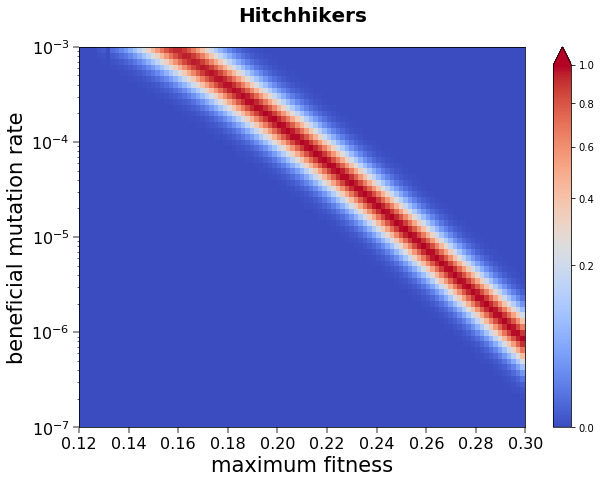

In [36]:
import matplotlib.colors as colors
import matplotlib.cbook as cbook

# Plotting the maximum likelihood estimates on a colormesh plot
plt.close('all')
#f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex = True, figsize=(16, 7))
f, ax1 = plt.subplots(1, 1, sharey=True, sharex = True, figsize=(10, 7))
#gs = matplotlib.gridspec.GridSpec(1, 2, width_ratios=[1, 1], height_ratios=[1])
#ax1 = plt.subplot(gs[0])
#ax2 = plt.subplot(gs[1])
#gs.update(wspace=0.4)

axisfont=17
titlefont=20
axislabelfont=21
tpfont = 14
m_size=8

#VAFs
#1 evaluation takes 2 minutes
s_list = s_eff_list
mu_ben_list = mu_eff_list
logProbs_hitch = likelihood_based_on_dist

# Plot the density map using nearest-neighbor interpolation
x1_hitch = s_list
y1_hitch = mu_ben_list
x1_hitch, y1_hitch = np.meshgrid(x1_hitch, y1_hitch)
logProbs_hitch_s = (-logProbs_hitch)
max_x, max_y = np.unravel_index(np.argmax(logProbs_hitch_s), logProbs_hitch_s.shape)
z_max = logProbs_hitch_s[max_x, max_y]
z1_hitch = np.exp(logProbs_hitch_s-(z_max))

cmap = plt.cm.coolwarm #define colors

# pcm=ax1.pcolormesh(x1_hitch,y1_hitch,z1_hitch,  norm=colors.SymLogNorm(linthresh=0.03, linscale=0.03,
#                                               vmin=-1.0, vmax=1.0), cmap = cmap)
# f.colorbar(pcm, ax=ax1, extend='both')

pcm=ax1.pcolormesh(x1_hitch,y1_hitch,z1_hitch, norm=colors.PowerNorm(gamma=0.5), cmap = cmap)
f.colorbar(pcm, ax=ax1, extend='max')


#norm=colors.LogNorm(vmin=z1_hitch.min(), vmax=z1_hitch.max())
#set labels
ax1.set_title("Hitchhikers", y = 1.05, fontsize = titlefont, fontweight='bold')
ax1.set_xlabel('maximum fitness', fontsize = axislabelfont)
ax1.set_ylabel('beneficial mutation rate', fontsize = axislabelfont)
ax1.set_ylim([10**-7, 10**-3])
#ax1.set_ylabel('\u03BC beneficials', fontsize = axislabelfont)

ax1.set_yscale('log')

# calculate best values for mu (max points in 3D space (x,y,z))
xmax, ymax = np.unravel_index(np.argmax(z1_hitch), z1_hitch.shape)
uben_max = y1_hitch[xmax, ymax]
s_max = x1_hitch[xmax, ymax]


#ax1.scatter(s_max, uben_max, marker = '+', s = 1000, color = grey1, lw = 5)

ax1.xaxis.set_tick_params(width=2, color = grey3, length = 6, labelsize = 16)
ax1.yaxis.set_tick_params(width=2, color = grey3, length = 6, labelsize = 16)


print('uben (ax1) = ', uben_max)
print('s (ax1) =', s_max)

#ax1.set_title('Hitchhikers', fontsize = 18)

# ## Mu_ben vs S
# logProbs_hitch = np.array([[logProbDataGivenModel_ages_hitch([2.27437637e-01, 3.48069520e-04, s, mu_ben], Neutral_densities_without_inf) for s in s_list] for mu_ben in mu_ben_list])

# # Plot the density map using nearest-neighbor interpolation
# x1_hitch_mu = mu_ben_list
# y1_hitch_mu = s_list
# x1_hitch_mu, y1_hitch_mu = np.meshgrid(x1_hitch_mu, y1_hitch_mu)
# logProbs_hitch_mu = (-logProbs_hitch)
# max_x_mu, max_y_mu = np.unravel_index(np.argmax(logProbs_hitch_mu), logProbs_hitch_mu.shape)
# z_max_mu = logProbs_hitch_mu[max_x_mu, max_y_mu]
# z1_hitch_mu = np.exp(logProbs_hitch_mu-(z_max_mu))

# cmap = plt.cm.coolwarm #define colors

# ax2.pcolormesh(x1_hitch_mu,y1_hitch_mu,z1_hitch_mu, cmap = cmap)

# #set labels
# ax2.set_xlabel('mu_ben', fontsize = axislabelfont)
# ax2.set_ylabel('s(%)', fontsize = axislabelfont)

# ax2.set_xscale('log')

# # calculate best values (max points in 3D space (x,y,z))
# xmax_mu, ymax_mu = np.unravel_index(np.argmax(z1_hitch_mu), z1_hitch_mu.shape)
# s_max = y1_hitch_mu[xmax_mu, ymax_mu]
# max_mu = x1_hitch_mu[xmax_mu, ymax_mu]
# z_max = z1_hitch_mu[xmax_mu, ymax_mu]

# ax2.xaxis.set_tick_params(width=2, color = grey3, length = 6, labelsize = 16)
# ax2.yaxis.set_tick_params(width=2, color = grey3, length = 6, labelsize = 16)

# ax2.scatter(max_mu, s_max, marker = '+', s = 1000, color = grey1, lw = 5)

# print('')
# print('mu_ben (ax2) = ', max_mu)
# print('s (ax2) =', s_max)
#plt.savefig('Likelihood_100x100_June_2019.pdf', bbox_inches='tight')
plt.show()
#plt.savefig('MLE_20x20.pdf', bbox_inches='tight')

# Plot MLE histrogram

In [10]:
def plot_log_hist_data_for_plot_solid_smaller(study_VAFs, study_total, study_mu, bin_size, study_name, marker_name, marker_size, color):
    #for plotting graphs that will not span the full width of the page and so will need larger markers
    log_VAFs = []
    for i in study_VAFs:
        log_VAFs.append(np.log(float(i)))
    normed_value = study_total*2*study_mu
#     bin_size = int((max(log_VAFs)-min(log_VAFs))/(1/((len(log_VAFs))**(1/3))))
    hist, bins = np.histogram(log_VAFs, bins=bin_size, range=(min(log_VAFs),max(log_VAFs)))
    widths = np.diff(bins)
    bin_centres = (bins[:-1] + bins[1:])/2
    hist = np.array(hist, dtype=float)
    normalised_hist = hist/(normed_value*widths)
    log_hist_for_plot = np.log(normalised_hist)
    
    errors = error_bars(hist, normed_value, widths)
    
    axisfont=14*scale
    axislabelfont=15*scale
    tpfont = 14*scale

    m_size = 18*scale
    m_width = 1.5*scale
    c_size = 3*scale
    c_thick = 1.5*scale
    e_width = 1.5*scale

    Jaiswalmarker = 'o'
    Zinkmarker = '^'
    Acunamarker = 'P'
    Coombsmarker = 'v'
    Youngmarker = 'p'
    Mckerrelmarker = 'D'
    Genovesemarker = 'd'
    Desaimarker = '*'
    Abelsonmarker = '>'

    #Colors
    DNMT3A_color = 'dodgerblue'
    R882_color = c1
    neutralcolor = c3
    
    #Plot
    ax1.errorbar(bin_centres, log_hist_for_plot, yerr= errors, fmt = marker_name, ecolor = color, \
             elinewidth = e_width, capsize = c_size, capthick = c_thick, markersize = marker_size, markeredgewidth = m_width, \
             markeredgecolor = color, markerfacecolor = color, label = study_name, zorder=0)
    
    # Set axis limits
    ax1.set_ylim(1, 14)
    ax1.set_xlim(-9, 0)
    # ax1.set_xlim(-7.6, 0)

    # Axis labels
    ax1.set_xlabel('variant allele frequency (%)', fontsize = axislabelfont, labelpad = 6*scale, fontweight = 'medium')
    ax1.set_ylabel('relative density of variants', fontsize = axislabelfont, labelpad = 6*scale, fontweight = 'medium')

    x_major_ticks = [np.log(0.0001),np.log(0.0002),np.log(0.0003),np.log(0.0004),np.log(0.0005),np.log(0.0006),np.log(0.0007),np.log(0.0008), np.log(0.0009),\
                     np.log(0.001), np.log(0.002),np.log(0.003),np.log(0.004),np.log(0.005),np.log(0.006),np.log(0.007),np.log(0.008),np.log(0.009), \
                     np.log(0.01),np.log(0.02),np.log(0.03),np.log(0.04),np.log(0.05),np.log(0.06),np.log(0.07),np.log(0.08),np.log(0.09),\
                     np.log(0.1),np.log(0.2),np.log(0.3),np.log(0.4),np.log(0.5),np.log(0.6),np.log(0.7),np.log(0.8),np.log(0.9), np.log(1.0)]
    x_major_tick_labels = ["0.01","","","","","","","","",\
                           "0.1","","","","","","","","",\
                           "1","","","","","","","","",\
                           "10","","","","50","","","","",""]
    ax1.set_xticks(x_major_ticks)
    ax1.set_xticklabels(x_major_tick_labels, fontsize = axisfont)
    ax1.xaxis.set_tick_params(width=scale, color = grey3, length = 6)

    y_major_ticks = [np.log(1), np.log(2), np.log(3), \
                     np.log(4), np.log(5), np.log(6), \
                     np.log(7), np.log(8), np.log(9), \
                     np.log(10), np.log(20), np.log(30),\
                     np.log(40), np.log(50), np.log(60), \
                     np.log(70), np.log(80), np.log(90),\
                     np.log(100), np.log(200), np.log(300), \
                     np.log(400), np.log(500), np.log(600),\
                     np.log(700), np.log(800), np.log(900), \
                     np.log(1000), np.log(2000), np.log(3000),\
                    np.log(4000), np.log(5000), np.log(6000), \
                     np.log(7000), np.log(8000), np.log(9000),\
                    np.log(10000), np.log(20000), np.log(30000), \
                     np.log(40000), np.log(50000), np.log(60000),\
                    np.log(70000), np.log(80000), np.log(90000), \
                     np.log(100000), np.log(200000),np.log(300000),np.log(400000),np.log(500000),np.log(600000),\
                    np.log(700000),np.log(800000),np.log(900000),np.log(1000000)]
    y_major_tick_labels = ["","","", "", "", "", "", "", "", "$10^{1}$","", "", "", "", "", "", "", "", \
                           "$10^{2}$","", "", "", "", "", "", "", "", "$10^{3}$","", "", "", "", "", "", "", "", \
                           "$10^{4}$","", "", "", "", "", "", "", "", "$10^{5}$","", "", "", "", "", "", "", "", "$10^{6}$"]
    ax1.set_yticks(y_major_ticks)
    ax1.set_yticklabels(y_major_tick_labels, fontsize = axisfont)
    ax1.yaxis.set_tick_params(width=scale, color = grey3, length = 6)

    #Only show the required axis lines
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    for axis in ['bottom','left']:
        ax1.spines[axis].set_linewidth(1.5)

    for axis in ['bottom','left']:
        ax1.spines[axis].set_color(grey3)
        
    
#     #set panel legends
#     legend_marker_size = 8*scale
#     legend_elements = [Line2D([0], [0], marker = Jaiswalmarker, color = grey3, alpha = 0.4, markersize = legend_marker_size*1.1, \
#                               lw=0, label='Jaiswal 2014'),
#                        Line2D([0], [0], marker = Genovesemarker, color=grey3, alpha=0.4, markersize = legend_marker_size*1.1, \
#                               lw=0, label='Genovese 2014'),
#                        Line2D([0], [0], marker = Mckerrelmarker, color=grey3, alpha=0.4, markersize = legend_marker_size, \
#                               lw=0, label='McKerrel 2015'),
#                        Line2D([0], [0], marker = Zinkmarker, color=grey3, alpha=0.4, markersize = legend_marker_size*1.2, \
#                               lw=0, label='Zink 2017'),
#                       Line2D([0], [0], marker = Acunamarker, color=grey3, alpha=0.4, markersize = legend_marker_size*1.3, \
#                               lw=0, label='Acuna-Hidalgo 2017'),
#                       Line2D([0], [0], marker = Coombsmarker, color=grey3, alpha=0.4, markersize = legend_marker_size*1.2, \
#                               lw=0, label='Coombs 2017'),
#                       Line2D([0], [0], marker = Youngmarker, color=grey3, alpha=0.4, markersize = legend_marker_size*1.2, \
#                               lw=0, label='Young 2016 & 2019'),
#                        Line2D([0], [0], marker = Desaimarker, color=grey3, alpha=0.4, markersize = legend_marker_size*1.5, \
#                               lw=0, label='Desai 2018'),]

#     ax1.legend(ncol=1, handles=legend_elements, loc='center', bbox_to_anchor=(0.16, 0.2), frameon=0, fontsize = 16*scale)
    
    return ax1

C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log
C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in log
C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log
C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in log
C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log
C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value enco

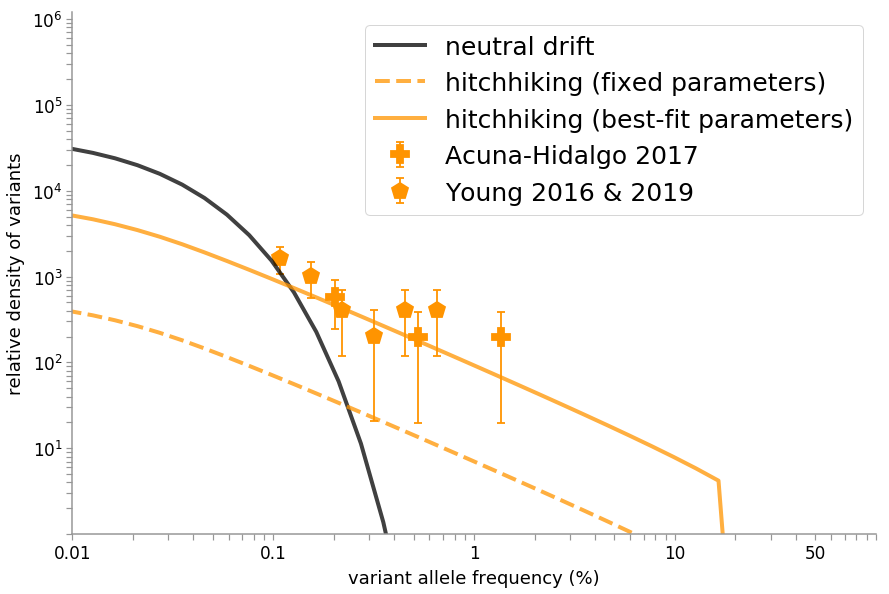

In [27]:
#Plotting the histogram
plt.close('all')
scale = 1.2
f, (ax1) = plt.subplots(1, 1, sharey=True, figsize=(12*scale, 8*scale))

Acunamarker = 'P' #plus sign
Youngmarker = 'p' #pentagon

neutralcolor=c3

m_size = 14
Jaiswalmarkersize = m_size*1.1
Genovesemarkersize = m_size*1.1
Zinkmarkersize = m_size*1.2
Acunamarkersize = m_size*1.3
Coombsmarkersize = m_size*1.2
Youngmarkersize = m_size*1.2
Desaimarkersize = m_size*1.5
McKerrelmarkersize = m_size*1
Liumarkersize = m_size*1

def SuperScriptinate(number):
    return number.replace('0','⁰').replace('1','¹').replace('2','²').replace('3','³').replace('4','⁴').replace('5','⁵').replace('6','⁶').replace('7','⁷').replace('8','⁸').replace('9','⁹').replace('-','⁻')

def sci_notation(number, sig_fig):
    ret_string = "{0:.{1:d}e}".format(number, sig_fig)
    a,b = ret_string.split("e")
    b = int(b)         # removed leading "+" and strips leading zeros too.
    return a + "x10^" + SuperScriptinate(str(b))


x=np.linspace(-10, -0.01, 40)

neutral_single_y=[logProbtheory_ages_single(l, 1) for l in x]
ax1.plot(x, neutral_single_y, c = 'black', lw = 4, alpha = 0.75, label= 'neutral drift')

[b, d, s_eff_best, mu_eff_best]=[0.33, 3.4e-04, 0.16, 3.8e-05]
hitchhiker_y=[logProbtheory_ages_hitch(l, [b, d, s_eff_best, mu_eff_best]) for l in x]

ax1.plot(x, hitchhiker_y, c = neutralcolor, lw = 4, linestyle='--', alpha = 0.75, label= 'hitchhiking (fixed parameters)')

[b, d, s_eff_best, mu_eff_best]=[0.33, 3.4e-04, 0.16, 5e-04]
hitchhiker_y=[logProbtheory_ages_hitch(l, [b, d, s_eff_best, mu_eff_best]) for l in x]

ax1.plot(x, hitchhiker_y, c = neutralcolor, lw = 4, alpha = 0.75, label= 'hitchhiking (best-fit parameters)')

#Synoymous variants (all genes)
plot_log_hist_data_for_plot_solid_smaller(Acuna_synonymous_trimmed_list, Acunatotal, Acuna_synonymous_mu, binmethod, \
                            'Acuna-Hidalgo 2017', Acunamarker, Acunamarkersize, neutralcolor)
plot_log_hist_data_for_plot_solid_smaller(Young2016_2019_synonymous_trimmed_list, Young2019totalcontrols+Youngtotal, Young_synonymous_mu, young_synonymous_bins, \
                            'Young 2016 & 2019', Youngmarker, Youngmarkersize, neutralcolor)

#Hitchhiker theory line with MLE values (including only synonymous variants with VAF >0.25%)
# mu_ben =  2.681812609453013e-06
# s = 0.19061965125701302








ax1.legend(prop={'size': 25})

#plt.savefig('hitchhiker_VAF_fixed_fitted_data_v2.pdf', bbox_inches='tight')
plt.show()

In [ ]:
mu_eff_list[4]

In [ ]:
s_eff_list[4]

In [ ]:
logProbtheory_ages_hitch(-3, [b,d,s_max,mu])

In [ ]:
logProbtheory_ages_hitch_eff(-3, mu_eff_best, s_eff_best) 

In [ ]:
Effective_y

In [ ]:
Distributed_y

In [ ]:
Effective_y

In [ ]:
t= None